In [1]:
# Import what we need for the script.

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from EqW import *

In [2]:
# Create a function which generates a gaussian.

def gaussian(x, mu, sig, pwr):
    return pwr * (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

In [3]:
# Load the 1D spectrum in the file.

flux = np.load('v_e_20180704_32_1_0_2.npy')
wavelength = np.load('wavelength.npy')
#flux = flux/np.mean(-flux)

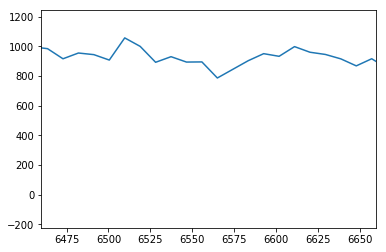

In [4]:
# Plot the 1D spectrum around the Ha line.

plt.plot(wavelength, flux)
plt.xlim((6460,6660))
#plt.ylim((-0.4e-17,0.2e-17))
plt.show()

In [5]:
# Define a continuum fit function.

def region_around_line(w, flux, cont):
    '''cut out and normalize flux around a line

    Parameters
    ----------
    w : 1 dim np.ndarray
        array of wanvelenghts
    flux : np.ndarray of shape (N, len(w))
        array of flux values for different spectra in the series
    cont : list of lists
        wavelengths for continuum normalization [[low1,up1],[low2, up2]]
        that described two areas on both sides of the line
    '''
    #index is true in the region where we fit the polynomial
    indcont = ((w > cont[0][0]) & (w < cont[0][1])) |((w > cont[1][0]) & (w < cont[1][1]))
    #index of the region we want to return
    indrange = (w > cont[0][0]) & (w < cont[1][1])
    fluxmean = np.mean(flux[:,np.where(indrange)])
    # make a flux array of shape
    # (nuber of spectra, number of pointsin indrange)
    f = np.zeros((flux.shape[0], indrange.sum()))
    for i in range(flux.shape[0]):
        # fit polynom of second order to the continuum region
        linecoeff = np.polyfit(w[indcont], flux[i, indcont],2)
        # devide the flux by the polynom and put the result in our
        # new flux array
        f[i,:] = flux[i,indrange]/np.polyval(linecoeff, w[indrange])
    if fluxmean < 0:
        f = -f
    f = f - np.mean(f)
    return w[indrange], f

In [6]:
# Define error functions for the optimisation of the gaussian fit. Penalise fits far from the Ha line using regularisation (check if this is appropriate).

def error(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.sum(np.power(flux - fit, 2.)) + 0.01 * np.power(mu - 6563, 2.)

def error2(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.power(flux - fit, 2.)

In [7]:
# Execute the continuum fit function.

#wha, fha = region_around_line(wavelength, np.reshape(flux, (1, np.size(flux))), [[6480, 6520],[6620, 6660]])
#wha, fha = region_around_line(wavelength, np.reshape(flux, (1, np.size(flux))), [[6400, 6520],[6600, 6730]])
wha, fha = region_around_line(wavelength, np.reshape(flux, (1, np.size(flux))), [[6300, 6520],[6620, 6720]])
fha = np.reshape(fha, np.size(wha))

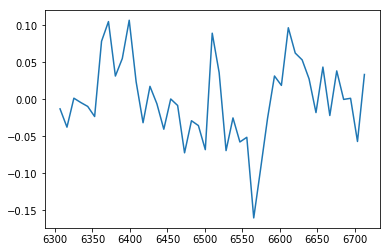

In [8]:
# Some plots.

#mu, sig, pwr = (6563, 3, -200)
#fit = gaussian(wha, mu, sig, pwr)
#data = mu, sig, pwr
#err = error2(data, fha, wha)
plt.plot(wha, fha)
#plt.plot(wha, err)
#plt.plot(wha, fit)
#plt.xlim((6440,6680))
#plt.ylim((-200,100))
plt.show()

In [9]:
# Import the scipy.optimize.minimize function

from scipy.optimize import minimize

In [10]:
# Define an initial guess for the gaussian parameters.

x0 = np.array((6563, 10, -20))

In [11]:
# Find the best fit mu, sig, pwr for the gaussian fit to the Ha line.

res = minimize(error, x0, args=(fha, wha), method='Nelder-Mead', tol=1e-6)
res.x

array([ 6.56788241e+03,  1.80000000e+00, -1.10891790e+00])

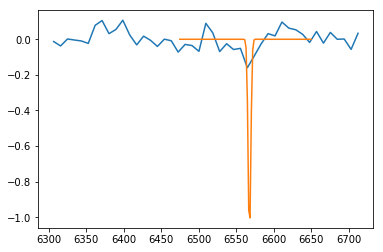

In [12]:
# Plot this fitted gaussian: (Not flux-conserved).

plt.plot(wha, fha)
plt.plot(np.linspace(6475, 6650, 100), gaussian(np.linspace(6475, 6650, 100), res.x[0], res.x[1], res.x[2]))
plt.show()

In [13]:
# Import SpectRes package to rebin the gaussian into the spectrum wavelength bins whilst conserving flux.

from spectres import spectres

In [14]:
# Define a new error function using SpectRes for the optimisation.

def reerr(data, w, f, gauw):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    res_fluxes = spectres(w, gauw, gaussian(gauw, mu, sig, pwr))
    return np.sum(np.power(f - res_fluxes, 2.)) + 0.01 * np.power(mu - 6563, 2.)

In [15]:
# Another best guess with constraints. Optimise it!

x0 = np.array((6563, 10, -5))
gauw = np.linspace(6200, 6750, 1000)
res = minimize(reerr, x0, args=(wha, fha, gauw), method='Nelder-Mead', tol=1e-6)
res.x

array([ 6.56303027e+03,  1.12969922e+01, -1.31877522e-01])

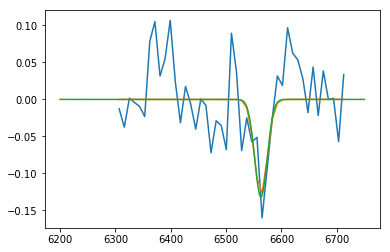

In [16]:
# Plot the normalised spectrum, the fitted gaussian and the fitted gaussian resampled into the spectrum wavelength bins.

plt.plot(wha, fha)
res_spec = spectres(wha, gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
plt.plot(wha, res_spec)
plt.plot(gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
plt.show()

In [17]:
# Calculate the equivalent width of the gaussian based on the best fit parameters.

ew = (np.sum(gaussian(gauw, res.x[0], res.x[1], res.x[2]))/res.x[2])*((gauw[1]-gauw[0])/(wha[1]-wha[0]))

ew

3.070865428075935

In [18]:
def halinefit(file, rang):
    
    flux = np.load(file)
    wavelength = np.load('wavelength.npy')
    
    wha, fha = region_around_line(wavelength, np.reshape(flux, (1, np.size(flux))), rang)
    fha = np.reshape(fha, np.size(wha))
    
    plt.plot(wavelength, flux)
    plt.xlim((rang[0][0]-10,rang[1][1]+10))
    plt.ylim((-0.4e-17,0.2e-17))
    plt.show()
    
    x0 = np.array((6563, 10, -5))
    gauw = np.linspace(rang[0][0]-10, rang[1][1]+10, 1000)
    res = minimize(reerr, x0, args=(wha, fha, gauw), method='Nelder-Mead', tol=1e-6)
    
    plt.plot(wha, fha)
    res_spec = spectres(wha, gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    plt.plot(gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    plt.show()
    
    ew = (np.sum(gaussian(gauw, res.x[0], res.x[1], res.x[2]))/res.x[2])*((gauw[1]-gauw[0])/(wha[1]-wha[0]))
    
    print(res.x)
    
    return ew
    

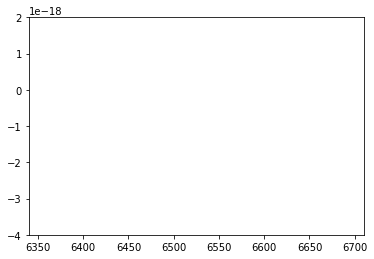

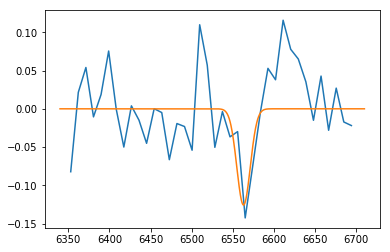

[ 6.56306199e+03  8.16136096e+00 -1.25696846e-01]


2.218505671764584

In [19]:
halinefit('v_e_20180704_32_1_0_2.npy', [[6350, 6450],[6650, 6700]])

In [20]:
wavelength

array([4020.        , 4029.2212963 , 4038.44259259, 4047.66388889,
       4056.88518519, 4066.10648148, 4075.32777778, 4084.54907407,
       4093.77037037, 4102.99166667, 4112.21296296, 4121.43425926,
       4130.65555556, 4139.87685185, 4149.09814815, 4158.31944444,
       4167.54074074, 4176.76203704, 4185.98333333, 4195.20462963,
       4204.42592593, 4213.64722222, 4222.86851852, 4232.08981481,
       4241.31111111, 4250.53240741, 4259.7537037 , 4268.975     ,
       4278.1962963 , 4287.41759259, 4296.63888889, 4305.86018519,
       4315.08148148, 4324.30277778, 4333.52407407, 4342.74537037,
       4351.96666667, 4361.18796296, 4370.40925926, 4379.63055556,
       4388.85185185, 4398.07314815, 4407.29444444, 4416.51574074,
       4425.73703704, 4434.95833333, 4444.17962963, 4453.40092593,
       4462.62222222, 4471.84351852, 4481.06481481, 4490.28611111,
       4499.50740741, 4508.7287037 , 4517.95      , 4527.1712963 ,
       4536.39259259, 4545.61388889, 4554.83518519, 4564.05648